# ML AS 1 



In [40]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import sklearn
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

In [41]:
class MNIST_Dataset(Dataset): 
    def __init__(self,filename): 
        self.data = torch.load(filename)[0]
        self.labels = torch.load(filename)[1]
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [5]:
def train(loader, model, loss_func, optimizer):
    size = len(loader.dataset)
    for batch, (X, y) in enumerate(loader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(loader, model):
    size = len(loader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [15]:
#taken from lady
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

In [13]:
batch_size = 64
mnist_real_train = MNIST_Dataset("MNIST/processed/training.pt")

mnist_train, mnist_validation = data.random_split(mnist_real_train, (48000, 12000))


train_dataloader = DataLoader(mnist_train, batch_size=batch_size)
validation_dataloader = DataLoader(mnist_validation, batch_size=batch_size)

mnist_test = MNIST_Dataset("MNIST/processed/test.pt")
test_dataloader = DataLoader(mnist_test, batch_size=batch_size)
# train()
len(mnist_real_train), len(mnist_train), len(mnist_validation), len(mnist_test)

(60000, 48000, 12000, 10000)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)
Epoch 1
-------------------------------
loss: 10.468575  [    0/48000]
loss: 1.807958  [ 6400/48000]
loss: 1.852179  [12800/48000]
loss: 1.553096  [19200/48000]
loss: 1.878364  [25600/48000]
loss: 1.816869  [32000/48000]
loss: 2.016561  [38400/48000]
loss: 1.907539  [44800/48000]
Test Error: 
 Accuracy: 30.2%, Avg loss: 0.029126 

Epoch 2
-------------------------------
loss: 1.942828  [    0/48000]
loss: 1.767803  [ 6400/48000]
loss: 1.836094  [12800/48000]
loss: 1.550366  [19200/48000]
loss: 1.871693  [25600/48000]
loss: 1.813582  [32000/48000]
loss: 1.993218  [38400/48000]
loss: 1.860919  [44800/48000]
Test Error: 
 Accuracy: 30.5%, Avg 

In [70]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
      
        self.cnn_layers = nn.Sequential(
            # 2D convolution layer
            nn.Conv2d(64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
           
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )
    def forward(self, x):
        t = self.cnn_layers(x)
        sz = 0
        fl = -1
        t = t.view(t.size(sz), fl)
        logits = self.linear_relu_stack(t)
        return logits

model = ConvNeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

TypeError: __init__() missing 1 required positional argument: 'out_channels'

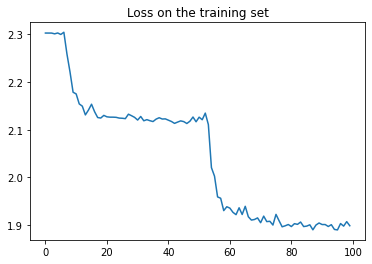

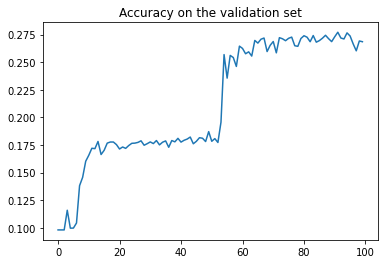

In [42]:
opt = optim.Adam(model.parameters())
cost = torch.nn.CrossEntropyLoss()

loss_values = []
acc_values = []
batch_size = 128
n_epoch = 100

for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch.float())
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    loss_values.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    logits = model(X.float())
    acc = compute_acc(logits, y)
    acc_values.append(acc)

plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

# print(loss_values)
# print(acc_values)

In [30]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, ConcatDataset

In [33]:
# Configuration parameters for k-fold evaluation 
k_folds = 5
num_epochs = 1
loss_function = nn.CrossEntropyLoss()

# Array for fold results 
results = {}

# Set fixed random number seed
torch.manual_seed(42)

#concated dataset for folding into new splits 
dataset = ConcatDataset([mnist_train, mnist_test, mnist_validation])


def resetWeights(m):
  '''
      A function to try to reset model weights and avoid leaks
  '''
  for layer in m.children():
   # if the layer can reset than call that funct     
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()


In [39]:
# Define the cross Validator for the K-fold and suffle to increace variablility 
kfold = KFold(n_splits=k_folds, shuffle=True)
#K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=100, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=100, sampler=test_subsampler)
    
    for epoch in range(n_epoch):
        print(f'Starting epoch {epoch+1}')
        current_loss = 0.0
        
        
        #iterate over the DataLoader for training data
        for i, data in enumerate(trainloader,0):
            #Get inputs
            inputs, targets = data
            
            #Zero the gradients 
            opt.zero_grad()
            
            #Perform forward pass
            outputs = model(inputs.float())
            
            #Compute loss 
            loss = loss_function(outputs,targets)
            
            #backprop
            loss.backward()
            
            #release stats to term 
            current_loss += loss.item()
            if i % 500 == 499:
                print('Loss after mini-batch %5d: %.3f' %
                      (i + 1, current_loss / 500))
                current_loss = 0.0
        # Process is complete.
    print('Training process has finished. Saving trained model.')

    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch.float())
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    loss_values.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    logits = model(X.float())
    acc = compute_acc(logits, y)
    acc_values.append(acc)


FOLD 0
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 2.302
Starting epoch 2
Loss after mini-batch   500: 2.302
Starting epoch 3
Loss after mini-batch   500: 2.302
Starting epoch 4
Loss after mini-batch   500: 2.302
Starting epoch 5
Loss after mini-batch   500: 2.302
Starting epoch 6
Loss after mini-batch   500: 2.302
Starting epoch 7
Loss after mini-batch   500: 2.302
Starting epoch 8
Loss after mini-batch   500: 2.302
Starting epoch 9
Loss after mini-batch   500: 2.302
Starting epoch 10
Loss after mini-batch   500: 2.302
Starting epoch 11
Loss after mini-batch   500: 2.302
Starting epoch 12
Loss after mini-batch   500: 2.302
Starting epoch 13
Loss after mini-batch   500: 2.302
Starting epoch 14
Loss after mini-batch   500: 2.302
Starting epoch 15
Loss after mini-batch   500: 2.302
Starting epoch 16
Loss after mini-batch   500: 2.302
Starting epoch 17
Loss after mini-batch   500: 2.302
Starting epoch 18
Loss after mini-batch   500: 2.302
Starting epoch 

AttributeError: 'list' object has no attribute 'DataLoader'

In [25]:
opt = optim.SGD(model.parameters(),.01)
cost = torch.nn.CrossEntropyLoss()

loss_values = []
acc_values = []
batch_size = 128
n_epoch = 100

for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch.float())
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    loss_values.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    logits = model(X.float())
    acc = compute_acc(logits, y)
    acc_values.append(acc)

plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

print(loss_values)
print(acc_values)

KeyboardInterrupt: 